In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# What is Stacking?
Stacking combines predictions from multiple different models (e.g., Logistic, Random Forest, XGBoost) and feeds them into a meta-model that learns how to best combine them.

Each base model makes predictions.

The meta-model (often Logistic Regression) takes those predictions as inputs and learns how to weigh them.

It often performs better than any individual model!

# What We’ll Use:
Base models: Logistic Regression, Random Forest, Gradient Boosting

Meta-model: Logistic Regression

Library: sklearn.ensemble.StackingClassifier

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")


In [4]:
# Fill missing values
train["Age"].fillna(train["Age"].median(), inplace=True)
test["Age"].fillna(train["Age"].median(), inplace=True)

train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)
test["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)

test["Fare"].fillna(test["Fare"].median(), inplace=True)

# New features
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

train["IsAlone"] = (train["FamilySize"] == 1).astype(int)
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)

# One-hot encoding
train = pd.get_dummies(train, columns=["Sex", "Embarked"], drop_first=True)
test = pd.get_dummies(test, columns=["Sex", "Embarked"], drop_first=True)


/tmp/ipykernel_13/2400371035.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Age"].fillna(train["Age"].median(), inplace=True)
/tmp/ipykernel_13/2400371035.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [5]:
features = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone", "Sex_male", "Embarked_Q", "Embarked_S"]
X = train[features]
y = train["Survived"]
X_test_final = test[features]


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [8]:
from sklearn.ensemble import StackingClassifier

# Base models
base_models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking Classifier
stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

stack_model.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

Validation Accuracy: 0.8156424581005587

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



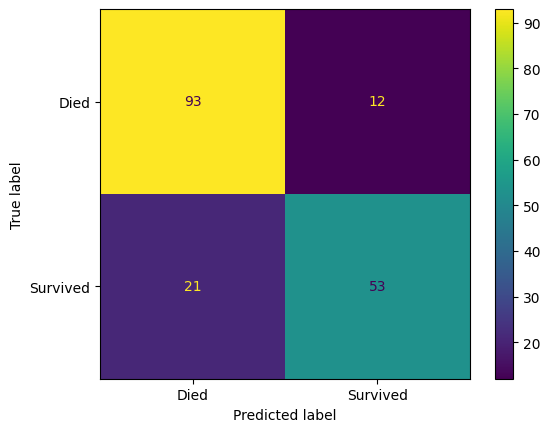

In [9]:
val_preds = stack_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report:\n", classification_report(y_val, val_preds))

cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Died", "Survived"])
disp.plot()


In [10]:
final_preds = stack_model.predict(X_test_scaled)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": final_preds.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("Stacking submission created!")


Stacking submission created!
